简单介绍一下卷积的常用trick：
- Padding
- Striding

下方是输入输出公式（本人开始也很困惑，找到对应公式后，就十分明朗了）：

n:原始输入的维度 | f:卷积核的大小 | p：padding的大小| s:stride的大小

no padding: n - f + 1

padding: n + 2*p -f + 1

stride with padding : (n+2*p−f)/s + 1 (该公式包含了上述两种情况)

#### MNIST

100%|██████████| 9.91M/9.91M [00:08<00:00, 1.14MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 136kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.09MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 1.48MB/s]
c:\Users\33398\.conda\envs\transformer\lib\site-packages\torchvision\datasets\mnist.py:76: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


torch.Size([60000, 28, 28])


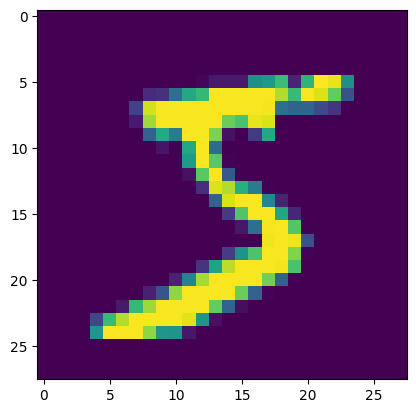

torch.Size([10000, 28, 28])


c:\Users\33398\.conda\envs\transformer\lib\site-packages\torchvision\datasets\mnist.py:81: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
c:\Users\33398\.conda\envs\transformer\lib\site-packages\torchvision\datasets\mnist.py:71: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [3]:
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision
import matplotlib.pyplot as plt

torch.manual_seed(1)   # 为了每次的实验结果一致
# 设置超参数
epoches = 2
batch_size = 50
learning_rate = 0.001

# 训练集
train_data = torchvision.datasets.MNIST(
    root="./mnist/",  # 训练数据保存路径
    train=True,       # True为下载训练数据集，False为下载测试数据集
    transform=torchvision.transforms.ToTensor(),  # 数据范围已从(0-255)压缩到(0,1)
    download=True,  # 是否需要下载
)
# 显示训练集中的第一张图片
print(train_data.train_data.size())   # [60000,28,28]
plt.imshow(train_data.train_data[0].numpy())
plt.show()

# 测试集
test_data = torchvision.datasets.MNIST(root="./mnist/", train=False)
print(test_data.test_data.size())    # [10000, 28, 28]
test_x = torch.unsqueeze(test_data.test_data, dim=1).type(torch.FloatTensor)/255
test_y = test_data.test_labels

# 将训练数据装入Loader中
train_loader = train_loader = Data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True, num_workers=3)


In [4]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()   # 继承__init__功能
        ## 第一层卷积
        self.conv1 = nn.Sequential(
            # 输入[1,28,28]
            nn.Conv2d(
                in_channels=1,    # 输入图片的高度
                out_channels=16,  # 输出图片的高度
                kernel_size=5,    # 5x5的卷积核，相当于过滤器
                stride=1,         # 卷积核在图上滑动，每隔一个扫一次
                padding=2,        # 给图外边补上0
            ),
            # 经过卷积层 输出[16,28,28] 传入池化层
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)   # 经过池化 输出[16,14,14] 传入下一个卷积
        )
        ## 第二层卷积
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=16,    # 同上
                out_channels=32,
                kernel_size=5,
                stride=1,
                padding=2
            ),
            # 经过卷积 输出[32, 14, 14] 传入池化层
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)  # 经过池化 输出[32,7,7] 传入输出层
        )
        ## 输出层
        self.output = nn.Linear(in_features=32*7*7, out_features=10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)           # [batch, 32,7,7]
        x = x.view(x.size(0), -1)   # 保留batch, 将后面的乘到一起 [batch, 32*7*7]
        output = self.output(x)     # 输出[50,10]
        return output


In [5]:
def main():
    # cnn 实例化
    cnn = CNN()
    print(cnn)

    # 定义优化器和损失函数
    optimizer = torch.optim.Adam(cnn.parameters(), lr=learning_rate)
    loss_function = nn.CrossEntropyLoss()

    # 开始训练
    for epoch in range(epoches):
        print("进行第{}个epoch".format(epoch))
        for step, (batch_x, batch_y) in enumerate(train_loader):
            output = cnn(batch_x)  # batch_x=[50,1,28,28]
            loss = loss_function(output, batch_y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
			# 为了实时显示准确率
            if step % 50 == 0:
                test_output = cnn(test_x)
                pred_y = torch.max(test_output, 1)[1].data.numpy()
                accuracy = ((pred_y == test_y.data.numpy()).astype(int).sum()) / float(test_y.size(0))
                print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.numpy(), '| test accuracy: %.2f' % accuracy)


    test_output = cnn(test_x[:10])
    pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
    print(pred_y)
    print(test_y[:10])

if __name__ == "__main__":
    main()


CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (output): Linear(in_features=1568, out_features=10, bias=True)
)
进行第0个epoch
Epoch:  0 | train loss: 2.3034 | test accuracy: 0.14
Epoch:  0 | train loss: 0.4083 | test accuracy: 0.85
Epoch:  0 | train loss: 0.5555 | test accuracy: 0.89
Epoch:  0 | train loss: 0.2239 | test accuracy: 0.93
Epoch:  0 | train loss: 0.1272 | test accuracy: 0.95
Epoch:  0 | train loss: 0.1649 | test accuracy: 0.96
Epoch:  0 | train loss: 0.0559 | test accuracy: 0.96
Epoch:  0 | train loss: 0.1248 | test accuracy: 0.97
Epoch:  0 | train loss: 0.0344 | test accuracy: 0.97
Epoch:  0 | train loss: 0.1005 | test